In [2]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import torch
from matplotlib import pyplot as plt 
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset, SubsetRandomSampler
import os
import json
import torchvision 
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
import pandas as pd
from time import time
# from numpy.lib.stride_tricks import as_strided
from torchvision.datasets import ImageFolder
from torch import as_strided


device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# 数据处理

# 车辆分类数据集

In [3]:
PATH_CAR = "./车辆分类数据集/车辆分类数据集"
def compute_mean_std(dataset_path, img_size=(224, 224), batch_size=32):
    """
    计算图像数据集的均值和标准差
    :param dataset_path: 数据集路径（需为ImageFolder格式）
    :param img_size: 统一调整的图像尺寸
    :param batch_size: 批量处理大小
    :return: (mean, std) 各通道的均值和标准差
    """
    # 预处理：调整尺寸 + 转为Tensor
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor()  # 自动缩放到[0,1]
    ])
    
    # 加载数据集
    dataset = ImageFolder(dataset_path, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # 初始化统计变量
    mean = 0.
    std = 0.
    nb_samples = 0.
    
    # 遍历数据集计算
    for data, _ in tqdm(loader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)  # 展平H,W维度
        mean += data.mean(2).sum(0)  # 各通道均值求和
        std += data.std(2).sum(0)    # 各通道标准差求和
        nb_samples += batch_samples
    
    # 计算全局均值和标准差
    mean /= nb_samples
    std /= nb_samples
    return mean.tolist(), std.tolist()

mean, std = compute_mean_std(PATH_CAR)
print(f"均值: {mean}")  # 例如 [0.485, 0.456, 0.406]
print(f"标准差: {std}")  # 例如 [0.229, 0.224, 0.225]

  0%|          | 0/43 [00:00<?, ?it/s]

均值: [0.4101674556732178, 0.4220322370529175, 0.4358880817890167]
标准差: [0.19289539754390717, 0.19039973616600037, 0.1875486969947815]


In [4]:
# 固定随机种子
torch.manual_seed(42)

# 数据预处理
transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.005),  # 提前加噪声
    transforms.Normalize(mean=[0.410, 0.422, 0.435], std=[0.193, 0.190, 0.187]),
])

transform_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.410, 0.422, 0.435], std=[0.193, 0.190, 0.187]),
])

# 划分数据集
def split_dataset(root_path, test_size=0.2, val_size=0.2, random_seed=42):
    dataset = ImageFolder(root_path)
    indices = list(range(len(dataset)))
    labels = [label for _, label in dataset.imgs]
    
    # 分层拆分（保持类别比例）
    train_val_idx, test_idx = train_test_split(
        indices, test_size=test_size, random_state=random_seed, stratify=labels
    )
    train_idx, val_idx = train_test_split(
        train_val_idx, test_size=val_size/(1-test_size), random_state=random_seed, stratify=[labels[i] for i in train_val_idx]
    )
    return train_idx, val_idx, test_idx

# 加载数据集
dataset_full = ImageFolder(root=PATH_CAR)  # 不应用预处理
train_idx, val_idx, test_idx = split_dataset(PATH_CAR)

# 创建子集并应用预处理
dataset_train = Subset(dataset_full, train_idx)
dataset_train.dataset.transform = transform_train  # 训练集增强

dataset_val = Subset(dataset_full, val_idx)
dataset_val.dataset.transform = transform_test    # 验证集无增强

dataset_test = Subset(dataset_full, test_idx)
dataset_test.dataset.transform = transform_test

# 创建DataLoader
train_dl_vehicle = DataLoader(dataset_train, batch_size=32, shuffle=True)  # 训练集需打乱
val_dl_vehicle = DataLoader(dataset_val, batch_size=32, shuffle=False)
test_dl_vehicle = DataLoader(dataset_test, batch_size=32, shuffle=False)

print(f"训练集: {len(train_dl_vehicle)}, 验证集: {len(val_dl_vehicle)}, 测试集: {len(test_dl_vehicle)}")

训练集: 26, 验证集: 9, 测试集: 9


In [5]:
print(train_dl_vehicle.dataset)
for data, _ in train_dl_vehicle:
    print(_)
    break

tensor([0, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 1, 2, 1, 0, 2, 2, 1, 2, 1, 2,
        2, 2, 1, 1, 2, 0, 1, 1])


# 手写二维卷积

In [5]:
# # 根据im2col变为矩阵乘法
# def split_by_strides_np(X, kh, kw, s):
#     N, C, H, W = X.shape
#     oh = (H - kh) // s + 1
#     ow = (W - kw) // s + 1
#     print(X.strides)
#     strides = (*X.strides[:-2], X.strides[-2]*s, X.strides[-1]*s, *X.strides[-2:])
#     print(strides)
#     A = as_strided(X, shape=(N,C,oh,ow,kh,kw), strides=strides)
#     return A

np.tensordot可以指定对应的轴相乘，相乘完的轴就可以认为没了，然后将剩下的轴拼在一起
在使用的时候只要弄懂每个轴是什么物理意义，然后知道想要输出的形状是什么样子的就行了

例如这里A.shape(N,C,oh,ow,kh,kw),kernel.shape(n,c,kh,kw)我想要输出的样子是(N, n, oh, ow)所以axes[(1,4,5), (1,2,3)]

将C，c；kh，kh；kw，kw相乘，拼接成了(N,oh,ow,n)的形状，然后使用transpose调整一下位置即可

In [6]:
# def conv_np(X, kernel, stride=1, padding=0):
#     n, c, kh, kw = kernel.shape
#     A =split_by_strides_np(X, kh, kw, stride)
#     res=np.tensordot(A, kernel, axes=[(1,4,5), (1,2,3)])
#     res = res.transpose((0,3,1,2))
#     return  res

In [7]:
# X1 = np.arange(1,19, dtype=np.int32).reshape(1, 2,3,3)
# kernel = np.arange(1,9, dtype=np.int32).reshape(1, 2,2,2)
# res = conv_np(X1, kernel)
# print(res)

In [8]:
def split_by_strides(X, kh, kw, s):
    N, C, H, W = X.shape
    oh = (H - kh) // s + 1
    ow = (W - kw) // s + 1
    
    # 计算PyTorch张量的stride
    stride = list(X.stride())
    strides = (stride[0], stride[1], 
               stride[2]*s, stride[3]*s, 
               stride[2], stride[3])
    
    A = as_strided(X, size=(N, C, oh, ow, kh, kw), 
                  stride=strides)
    return A

def conv(X, kernel, stride=1, padding=0):
    if padding > 0:
        X = F.pad(X, (padding, padding, padding, padding))
    
    n, c, kh, kw = kernel.shape
    A = split_by_strides(X, kh, kw, stride)
    
    # 使用einsum实现张量收缩
    res = torch.einsum('nchwkl,ockl->nohw', A, kernel)
    return res

In [9]:
X1 = torch.randn((1, 2, 3, 3))
kernel = torch.randn((2, 2, 2, 2))
print(conv(X1, kernel))

tensor([[[[ 1.0150, -2.2959],
          [-1.0769, -1.8298]],

         [[-3.0585,  1.1344],
          [-2.7206, -0.3116]]]])


In [10]:
class MyConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(MyConv2D, self).__init__()
        self.stride = stride
        self.padding = padding
        if isinstance(kernel_size, int):
            kernel_size=(kernel_size, kernel_size)
        self.weight = nn.Parameter(torch.randn((out_channels, in_channels) + kernel_size))
        self.bias = nn.Parameter(torch.randn((out_channels ,1 ,1)))
        
        
    def forward(self, x):
        return conv(x, self.weight, self.stride, self.padding) + self.bias

In [11]:
my_conv = MyConv2D(2, 2, 2)
X = torch.randn((1, 2, 3, 3))
print(my_conv.forward(X))

tensor([[[[ 0.6105,  1.3167],
          [ 2.3634, -1.5142]],

         [[ 1.4184, -1.5113],
          [ 4.3302, -0.0240]]]], grad_fn=<AddBackward0>)


In [12]:
class ManualVehicleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
            MyConv2D(3, 64, 3), # 输出(64, 62, 62)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2), # 输出(64, 31, 31)
            MyConv2D(64, 64, 3), # 输出(64, 29, 29)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2), # 输出(64, 14, 14)
            MyConv2D(64, 128, 3), # 输出(128, 12, 12)
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2), # 输出(128, 6, 6)
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256), 
            nn.ReLU(),
            nn.Linear(256, 3)
        )
        self.init_weight()
        
    
    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
                
                
    def forward(self, x):
        return self.model(x)
        
        

In [6]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item())
        
        preds = logits.argmax(axis=-1)    # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())
        
    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc


In [7]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1
            
    @property
    def early_stop(self):
        return self.counter >= self.patience


In [15]:
# 训练
def training_manual_cnn(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    early_stop_callback=None,
    eval_step=100,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1) #最大值的索引
            
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())     # 计算准确率
                loss = loss.cpu().item() # 计算损失
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step # 记录每一步的损失和准确率
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()


                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict

In [16]:
epoch = 30
model_manual_vehicle = ManualVehicleCNN()
loss_fct_manual_vehicle = nn.CrossEntropyLoss()
optimizer_manual_vehicle = torch.optim.Adam(model_manual_vehicle.parameters(), lr=0.001)
early_stop_callback = EarlyStopCallback(patience=5)
model_manual_vehicle = model_manual_vehicle.to(device)
record_manual_vehicle = training_manual_cnn(
    model_manual_vehicle,
    train_dl_vehicle,
    val_dl_vehicle,
    epoch,
    loss_fct_manual_vehicle,
    optimizer_manual_vehicle,
    early_stop_callback=early_stop_callback,
    eval_step=100
    )

  0%|          | 0/780 [00:00<?, ?it/s]

Early stop at epoch 26 / global_step 700


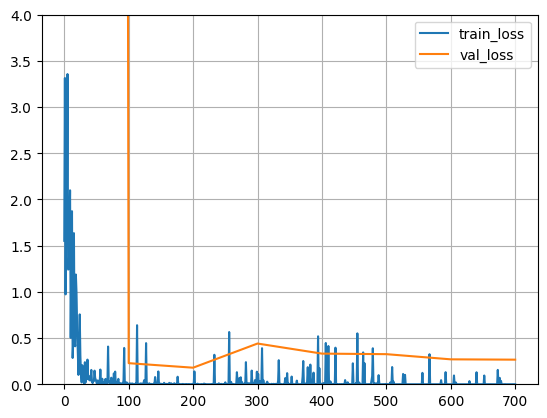

In [17]:
plt.plot([i["step"] for i in record_manual_vehicle["train"]], [i["loss"] for i in record_manual_vehicle["train"]], label="train_loss")
plt.plot([i["step"] for i in record_manual_vehicle["val"]], [i["loss"] for i in record_manual_vehicle["val"]], label="val_loss")
plt.grid()
plt.legend()
max_loss = max(
    max([i["loss"] for i in record_manual_vehicle["train"]]),
    max([i["loss"] for i in record_manual_vehicle["val"]])
)
plt.ylim(0, 4)  # 上浮10%留出余量
plt.show()

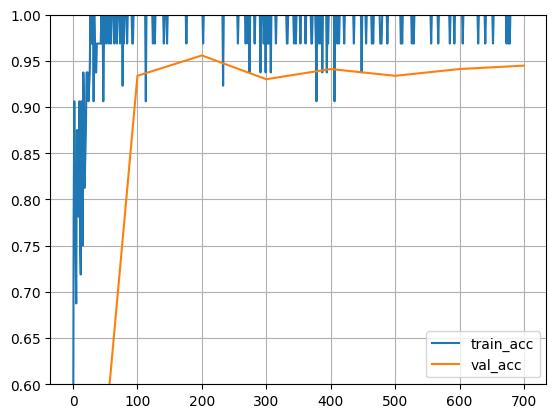

In [18]:
plt.plot([i["step"] for i in record_manual_vehicle["train"]], [i["acc"] for i in record_manual_vehicle["train"]], label="train_acc")
plt.plot([i["step"] for i in record_manual_vehicle["val"]], [i["acc"] for i in record_manual_vehicle["val"]], label="val_acc")
plt.grid()
plt.legend()
max_acc = max(
    max([i["acc"] for i in record_manual_vehicle["train"]]),
    max([i["acc"] for i in record_manual_vehicle["val"]])
)
plt.ylim(0.6, 1)  # 上浮10%留出余量
plt.show()

In [19]:
model_manual_vehicle.eval()
loss, acc= evaluating(model_manual_vehicle, test_dl_vehicle, loss_fct_manual_vehicle)
print(f"loss:     {loss:.4f}\nacc: {acc:.4f}")

loss:     0.2468
acc: 0.9632


In [219]:
print(len(train_dl_vehicle))

26


# torch.nn 实现CNN

In [20]:
class NnVehicleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2), # 输出(64, 31, 31)
            nn.Conv2d(64, 64, kernel_size=3, stride=1), # 输出(64, 29, 29)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2), # 输出(64, 14, 14)
            nn.Conv2d(64, 128, kernel_size=3, stride=1), # 输出(128, 12, 12)
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2), # 输出(128, 6, 6)
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256), 
            nn.ReLU(),
            nn.Linear(256, 3)
        )
        self.init_weight()
        
    
    def init_weight(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
                
                
    def forward(self, x):
        return self.model(x)
        
        

In [21]:
# 训练
def training_nn_cnn(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    early_stop_callback=None,
    eval_step=100,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1) #最大值的索引
            
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())     # 计算准确率
                loss = loss.cpu().item() # 计算损失
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step # 记录每一步的损失和准确率
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()


                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict

In [26]:
epoch = 50
model_nn_vehicle = NnVehicleCNN()
loss_fct_nn_vehicle = nn.CrossEntropyLoss()
optimizer_nn_vehicle = torch.optim.Adam(model_nn_vehicle.parameters(), lr=0.001)
early_stop_callback = EarlyStopCallback(patience=5)
model_nn_vehicle = model_nn_vehicle.to(device)
record_nn_vehicle = training_nn_cnn(
    model_nn_vehicle,
    train_dl_vehicle,
    val_dl_vehicle,
    epoch,
    loss_fct_nn_vehicle,
    optimizer_nn_vehicle,
    early_stop_callback=early_stop_callback,
    eval_step=100
    )

  0%|          | 0/1300 [00:00<?, ?it/s]

Early stop at epoch 34 / global_step 900


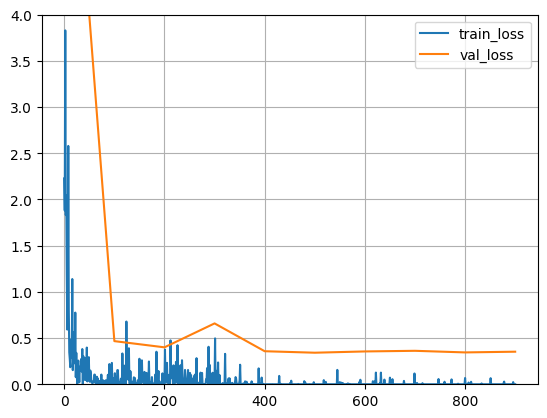

In [27]:
plt.plot([i["step"] for i in record_nn_vehicle["train"]], [i["loss"] for i in record_nn_vehicle["train"]], label="train_loss")
plt.plot([i["step"] for i in record_nn_vehicle["val"]], [i["loss"] for i in record_nn_vehicle["val"]], label="val_loss")
plt.grid()
plt.legend()
max_loss = max(
    max([i["loss"] for i in record_nn_vehicle["train"]]),
    max([i["loss"] for i in record_nn_vehicle["val"]])
)
plt.ylim(0, 4)  # 上浮10%留出余量
plt.show()

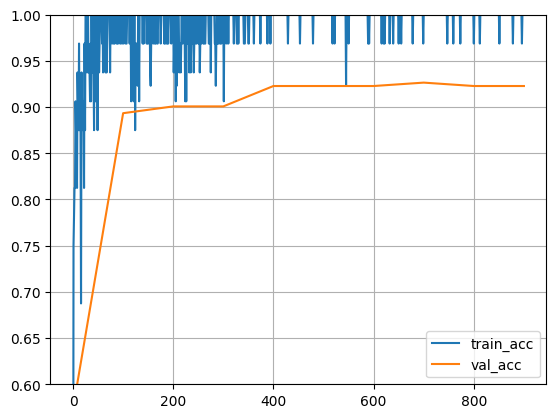

In [28]:
plt.plot([i["step"] for i in record_nn_vehicle["train"]], [i["acc"] for i in record_nn_vehicle["train"]], label="train_acc")
plt.plot([i["step"] for i in record_nn_vehicle["val"]], [i["acc"] for i in record_nn_vehicle["val"]], label="val_acc")
plt.grid()
plt.legend()
max_acc = max(
    max([i["acc"] for i in record_nn_vehicle["train"]]),
    max([i["acc"] for i in record_nn_vehicle["val"]])
)
plt.ylim(0.6, 1)  # 上浮10%留出余量
plt.show()

In [29]:
model_nn_vehicle.eval()
loss, acc= evaluating(model_nn_vehicle, test_dl_vehicle, loss_fct_nn_vehicle)
print(f"loss:     {loss:.4f}\nacc: {acc:.4f}")

loss:     0.3045
acc: 0.9596


# 超参数对比分析

# 学习率变大

In [30]:
epoch = 100
model_nn_vehicle_lr = NnVehicleCNN()
loss_fct_nn_vehicle_lr = nn.CrossEntropyLoss()
optimizer_nn_vehicle_lr = torch.optim.Adam(model_nn_vehicle_lr.parameters(), lr=0.01)
early_stop_callback = EarlyStopCallback(patience=5)
model_nn_vehicle_lr = model_nn_vehicle_lr.to(device)
record_nn_vehicle_lr = training_nn_cnn(
    model_nn_vehicle_lr,
    train_dl_vehicle,
    val_dl_vehicle,
    epoch,
    loss_fct_nn_vehicle_lr,
    optimizer_nn_vehicle_lr,
    early_stop_callback=early_stop_callback,
    eval_step=100
    )

  0%|          | 0/2600 [00:00<?, ?it/s]

Early stop at epoch 38 / global_step 1000


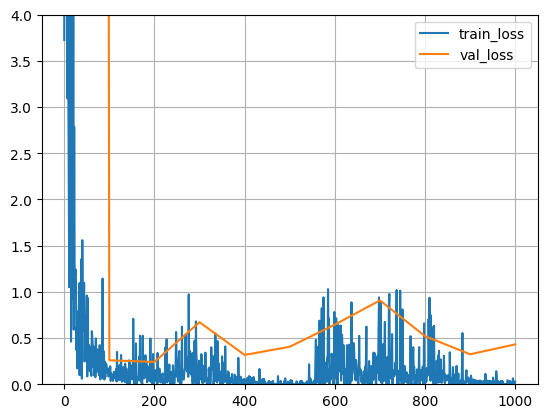

In [31]:
plt.plot([i["step"] for i in record_nn_vehicle_lr["train"]], [i["loss"] for i in record_nn_vehicle_lr["train"]], label="train_loss")
plt.plot([i["step"] for i in record_nn_vehicle_lr["val"]], [i["loss"] for i in record_nn_vehicle_lr["val"]], label="val_loss")
plt.grid()
plt.legend()
max_loss = max(
    max([i["loss"] for i in record_nn_vehicle_lr["train"]]),
    max([i["loss"] for i in record_nn_vehicle_lr["val"]])
)
plt.ylim(0, 4)  # 上浮10%留出余量
plt.show()

# 优化过程可能因学习率过大而“跳过”最优解，进入不稳定的参数空间。

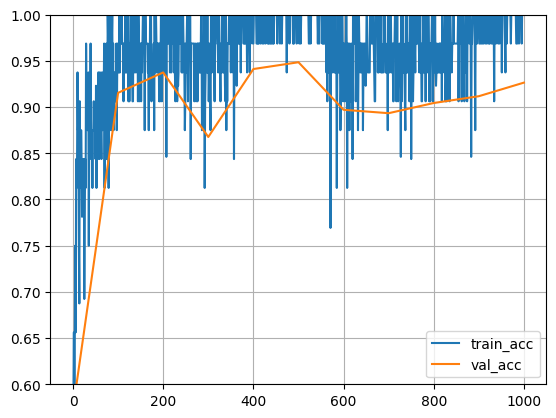

In [32]:
plt.plot([i["step"] for i in record_nn_vehicle_lr["train"]], [i["acc"] for i in record_nn_vehicle_lr["train"]], label="train_acc")
plt.plot([i["step"] for i in record_nn_vehicle_lr["val"]], [i["acc"] for i in record_nn_vehicle_lr["val"]], label="val_acc")
plt.grid()
plt.legend()
max_acc = max(
    max([i["acc"] for i in record_nn_vehicle_lr["train"]]),
    max([i["acc"] for i in record_nn_vehicle_lr["val"]])
)
plt.ylim(0.6, 1)  # 上浮10%留出余量
plt.show()

In [33]:
model_nn_vehicle_lr.eval()
loss, acc= evaluating(model_nn_vehicle_lr, test_dl_vehicle, loss_fct_nn_vehicle_lr)
print(f"loss:     {loss:.4f}\nacc: {acc:.4f}")

loss:     0.2556
acc: 0.9375


# 卷积核变大

In [34]:
class NnVehicleCNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2), # 输出(64, 30, 30)
            nn.Conv2d(64, 64, kernel_size=5, stride=1), # 输出(64, 26, 26)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2), # 输出(64, 13, 13)
            nn.Conv2d(64, 128, kernel_size=5, stride=1), # 输出(128, 9, 9)
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2), # 输出(128, 4, 4)
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256), 
            nn.ReLU(),
            nn.Linear(256, 3)
        )
        self.init_weight()
        
    
    def init_weight(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
                
                
    def forward(self, x):
        return self.model(x)
        
        

In [36]:
epoch = 50
model_nn_vehicle2 = NnVehicleCNN2()
loss_fct_nn_vehicle2 = nn.CrossEntropyLoss()
optimizer_nn_vehicle2 = torch.optim.Adam(model_nn_vehicle2.parameters(), lr=0.001)
early_stop_callback = EarlyStopCallback(patience=5)
model_nn_vehicle2 = model_nn_vehicle2.to(device)
record_nn_vehicle2 = training_nn_cnn(
    model_nn_vehicle2,
    train_dl_vehicle,
    val_dl_vehicle,
    epoch,
    loss_fct_nn_vehicle2,
    optimizer_nn_vehicle2,
    early_stop_callback=early_stop_callback,
    eval_step=100
    )

  0%|          | 0/1300 [00:00<?, ?it/s]

Early stop at epoch 30 / global_step 800


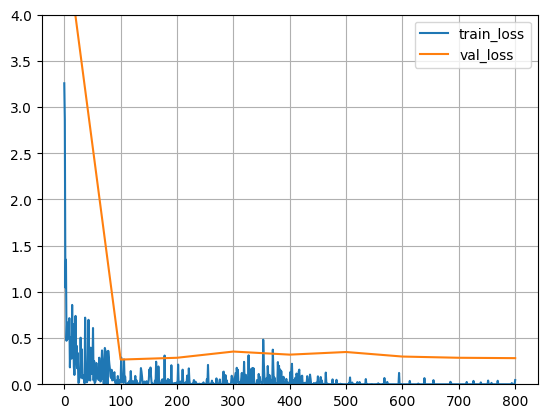

In [37]:
plt.plot([i["step"] for i in record_nn_vehicle2["train"]], [i["loss"] for i in record_nn_vehicle2["train"]], label="train_loss")
plt.plot([i["step"] for i in record_nn_vehicle2["val"]], [i["loss"] for i in record_nn_vehicle2["val"]], label="val_loss")
plt.grid()
plt.legend()
max_loss = max(
    max([i["loss"] for i in record_nn_vehicle2["train"]]),
    max([i["loss"] for i in record_nn_vehicle2["val"]])
)
plt.ylim(0, 4)  # 上浮10%留出余量
plt.show()

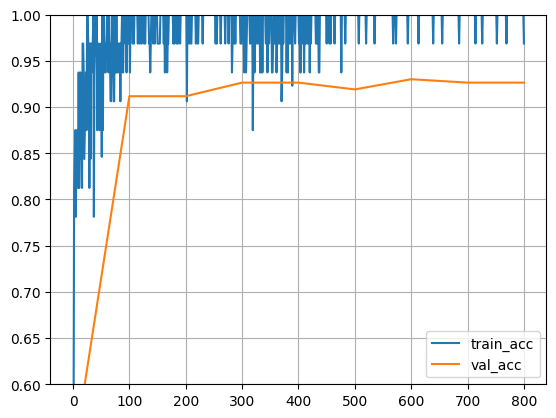

In [38]:
plt.plot([i["step"] for i in record_nn_vehicle2["train"]], [i["acc"] for i in record_nn_vehicle2["train"]], label="train_acc")
plt.plot([i["step"] for i in record_nn_vehicle2["val"]], [i["acc"] for i in record_nn_vehicle2["val"]], label="val_acc")
plt.grid()
plt.legend()
max_acc = max(
    max([i["acc"] for i in record_nn_vehicle2["train"]]),
    max([i["acc"] for i in record_nn_vehicle2["val"]])
)
plt.ylim(0.6, 1)  # 上浮10%留出余量
plt.show()

In [39]:
model_nn_vehicle2.eval()
loss, acc= evaluating(model_nn_vehicle2, test_dl_vehicle, loss_fct_nn_vehicle_lr)
print(f"loss:     {loss:.4f}\nacc: {acc:.4f}")

loss:     0.2318
acc: 0.9632


# AlexNet

In [40]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=5, stride=2), # 输出(96, 30, 30)
            nn.MaxPool2d(kernel_size=3, stride=2), # (96, 14, 14)
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding='same'), # (256, 14, 14)
            nn.MaxPool2d(kernel_size=3, stride=2), #(256, 6, 6)
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding='same'), # (384, 6, 6)
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding='same'),   #(384, 6, 6)
            nn.MaxPool2d(kernel_size=3, stride=2), #(384, 2, 2)
            nn.Flatten(),
            nn.Linear(384*2*2, 1024), 
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(1024, 1024), 
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(1024, 3)
        )
        
        self.init_weight()
        
    
    def init_weight(self):
       for m in self.modules():
           if isinstance(m, (nn.Linear, nn.Conv2d)):
               nn.init.kaiming_normal_(m.weight)
               nn.init.zeros_(m.bias)
    
    
    def forward(self, x):
        return self.model(x)

In [41]:
# 训练
def training_alexnet(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    early_stop_callback=None,
    eval_step=100,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1) #最大值的索引
            
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())     # 计算准确率
                loss = loss.cpu().item() # 计算损失
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step # 记录每一步的损失和准确率
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()


                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict

In [42]:
epoch = 100
model_alexnet = AlexNet()
loss_fct_alexnet = nn.CrossEntropyLoss()
optimizer_alexnet = torch.optim.Adam(model_alexnet.parameters(), lr=0.0001)
early_stop_callback = EarlyStopCallback(patience=5)
model_alexnet = model_alexnet.to(device)
record_alexnet = training_nn_cnn(
    model_alexnet,
    train_dl_vehicle,
    val_dl_vehicle,
    epoch,
    loss_fct_alexnet,
    optimizer_alexnet,
    early_stop_callback=early_stop_callback,
    eval_step=100
    )

  0%|          | 0/2600 [00:00<?, ?it/s]

Early stop at epoch 30 / global_step 800


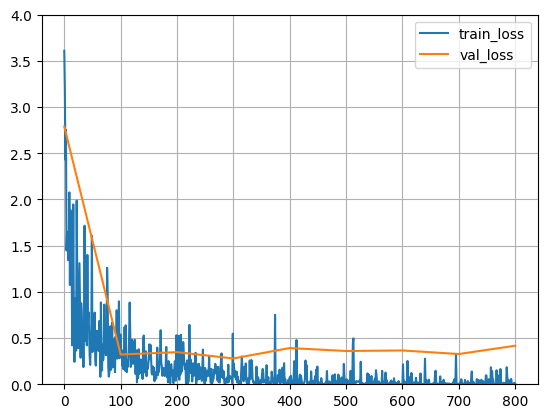

In [43]:
plt.plot([i["step"] for i in record_alexnet["train"]], [i["loss"] for i in record_alexnet["train"]], label="train_loss")
plt.plot([i["step"] for i in record_alexnet["val"]], [i["loss"] for i in record_alexnet["val"]], label="val_loss")
plt.grid()
plt.legend()
max_loss = max(
    max([i["loss"] for i in record_alexnet["train"]]),
    max([i["loss"] for i in record_alexnet["val"]])
)
plt.ylim(0, 4)  # 上浮10%留出余量
plt.show()

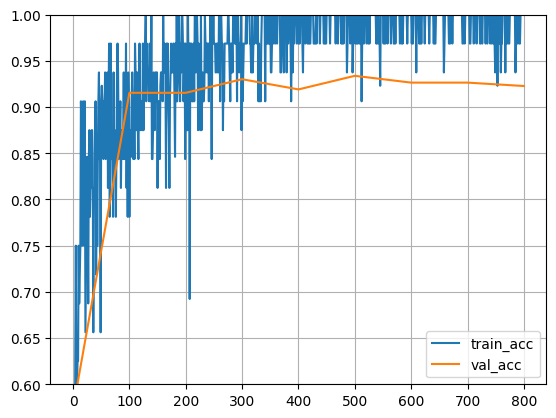

In [45]:
plt.plot([i["step"] for i in record_alexnet["train"]], [i["acc"] for i in record_alexnet["train"]], label="train_acc")
plt.plot([i["step"] for i in record_alexnet["val"]], [i["acc"] for i in record_alexnet["val"]], label="val_acc")
plt.grid()
plt.legend()
max_acc = max(
    max([i["acc"] for i in record_alexnet["train"]]),
    max([i["acc"] for i in record_alexnet["val"]])
)
plt.ylim(0.6, 1)  # 上浮10%留出余量
plt.show()

In [48]:
model_alexnet.eval()
loss, acc= evaluating(model_alexnet, test_dl_vehicle, loss_fct_nn_vehicle_lr)
print(f"loss:     {loss:.4f}\nacc: {acc:.4f}")

loss:     0.3095
acc: 0.9412


# 空洞卷积[1,2,5]

In [49]:
class NnVehicleCNNDilated(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, dilation=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2), # 输出(64, 30, 30)
            nn.Conv2d(64, 64, kernel_size=3, stride=1, dilation=2), # 输出(64, 26, 26)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2), # 输出(64, 13, 13)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, dilation=5), # 输出(128, 3, 3)
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256), 
            nn.ReLU(),
            nn.Linear(256, 3)
        )
        self.init_weight()
        
    
    def init_weight(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
                
                
    def forward(self, x):
        return self.model(x)
        
        

In [9]:
# 训练
def training_dialted(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    early_stop_callback=None,
    eval_step=100,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1) #最大值的索引
            
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())     # 计算准确率
                loss = loss.cpu().item() # 计算损失
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step # 记录每一步的损失和准确率
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()


                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict

In [51]:
epoch = 100
model_dialted = NnVehicleCNNDilated()
loss_fct_dialted = nn.CrossEntropyLoss()
optimizer_dialted = torch.optim.Adam(model_dialted.parameters(), lr=0.001)
early_stop_callback = EarlyStopCallback(patience=5)
model_dialted = model_dialted.to(device)
record_dialted = training_dialted(
    model_dialted,
    train_dl_vehicle,
    val_dl_vehicle,
    epoch,
    loss_fct_dialted,
    optimizer_dialted,
    early_stop_callback=early_stop_callback,
    eval_step=100
    )

  0%|          | 0/2600 [00:00<?, ?it/s]

Early stop at epoch 26 / global_step 700


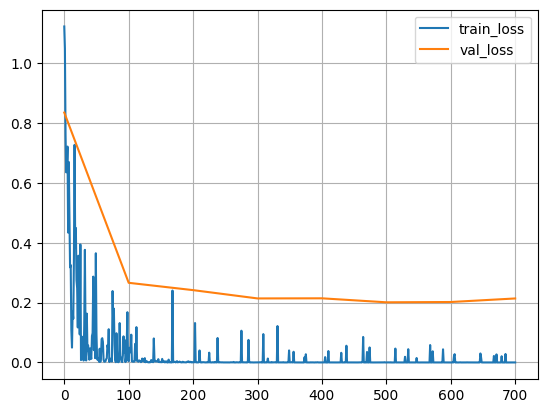

In [52]:
plt.plot([i["step"] for i in record_dialted["train"]], [i["loss"] for i in record_dialted["train"]], label="train_loss")
plt.plot([i["step"] for i in record_dialted["val"]], [i["loss"] for i in record_dialted["val"]], label="val_loss")
plt.grid()
plt.legend()
max_loss = max(
    max([i["loss"] for i in record_dialted["train"]]),
    max([i["loss"] for i in record_dialted["val"]])
)
# plt.ylim(0, 4)  # 上浮10%留出余量
plt.show()

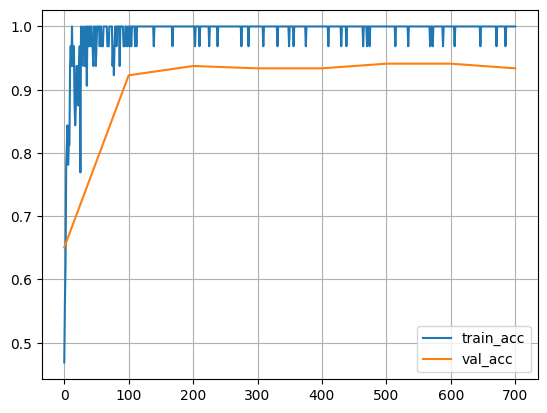

In [53]:
plt.plot([i["step"] for i in record_dialted["train"]], [i["acc"] for i in record_dialted["train"]], label="train_acc")
plt.plot([i["step"] for i in record_dialted["val"]], [i["acc"] for i in record_dialted["val"]], label="val_acc")
plt.grid()
plt.legend()
max_acc = max(
    max([i["acc"] for i in record_dialted["train"]]),
    max([i["acc"] for i in record_dialted["val"]])
)
# plt.ylim(0.6, 1)  # 上浮10%留出余量
plt.show()

In [54]:
model_dialted.eval()
loss, acc= evaluating(model_dialted, test_dl_vehicle, loss_fct_dialted)
print(f"loss:     {loss:.4f}\nacc: {acc:.4f}")

loss:     0.1772
acc: 0.9449


# 膨胀卷积[2,2,4]视野域和[1,2,5]一致

In [55]:
class NnVehicleCNNDilated2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2), # 输出(64, 30, 30)
            nn.Conv2d(64, 64, kernel_size=3, stride=1, dilation=2), # 输出(64, 26, 26)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2), # 输出(64, 13, 13)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, dilation=4), # 输出(128, 5, 5)
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Flatten(),
            nn.Linear(128 * 5 * 5, 256), 
            nn.ReLU(),
            nn.Linear(256, 3)
        )
        self.init_weight()
        
    
    def init_weight(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
                
                
    def forward(self, x):
        return self.model(x)
        
        

In [56]:
epoch = 100
model_dialted2 = NnVehicleCNNDilated2()
loss_fct_dialted = nn.CrossEntropyLoss()
optimizer_dialted = torch.optim.Adam(model_dialted2.parameters(), lr=0.001)
early_stop_callback = EarlyStopCallback(patience=5)
model_dialted2 = model_dialted2.to(device)
record_dialted = training_dialted(
    model_dialted2,
    train_dl_vehicle,
    val_dl_vehicle,
    epoch,
    loss_fct_dialted,
    optimizer_dialted,
    early_stop_callback=early_stop_callback,
    eval_step=100
    )

  0%|          | 0/2600 [00:00<?, ?it/s]

Early stop at epoch 30 / global_step 800


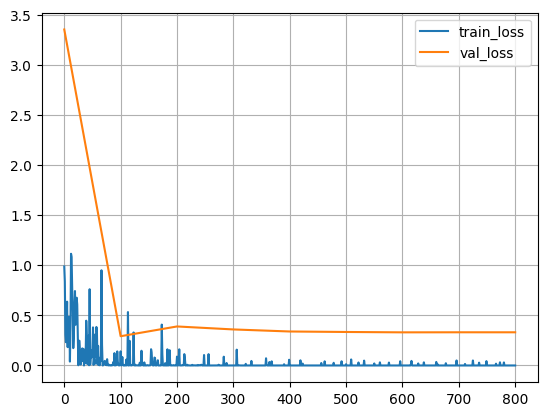

In [57]:
plt.plot([i["step"] for i in record_dialted["train"]], [i["loss"] for i in record_dialted["train"]], label="train_loss")
plt.plot([i["step"] for i in record_dialted["val"]], [i["loss"] for i in record_dialted["val"]], label="val_loss")
plt.grid()
plt.legend()
max_loss = max(
    max([i["loss"] for i in record_dialted["train"]]),
    max([i["loss"] for i in record_dialted["val"]])
)
# plt.ylim(0, 4)  # 上浮10%留出余量
plt.show()

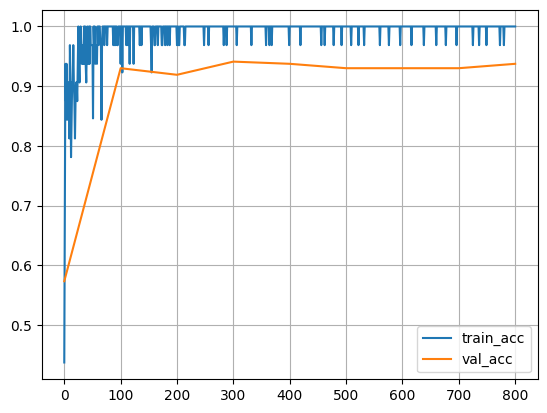

In [58]:
plt.plot([i["step"] for i in record_dialted["train"]], [i["acc"] for i in record_dialted["train"]], label="train_acc")
plt.plot([i["step"] for i in record_dialted["val"]], [i["acc"] for i in record_dialted["val"]], label="val_acc")
plt.grid()
plt.legend()
max_acc = max(
    max([i["acc"] for i in record_dialted["train"]]),
    max([i["acc"] for i in record_dialted["val"]])
)
# plt.ylim(0.6, 1)  # 上浮10%留出余量
plt.show()

In [59]:
model_dialted2.eval()
loss, acc= evaluating(model_dialted2, test_dl_vehicle, loss_fct_dialted)
print(f"loss:     {loss:.4f}\nacc: {acc:.4f}")

loss:     0.3351
acc: 0.9449


# 膨胀卷积[2, 2, 2]

In [8]:
class NnVehicleCNNDilated3(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2), # 输出(64, 30, 30)
            nn.Conv2d(64, 64, kernel_size=3, stride=1, dilation=2), # 输出(64, 26, 26)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2), # 输出(64, 13, 13)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, dilation=2), # 输出(128, 9, 9)
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256), 
            nn.ReLU(),
            nn.Linear(256, 3)
        )
        self.init_weight()
        
    
    def init_weight(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
                
                
    def forward(self, x):
        return self.model(x)
        
        

In [10]:
epoch = 100
model_dialted3 = NnVehicleCNNDilated3()
loss_fct_dialted = nn.CrossEntropyLoss()
optimizer_dialted = torch.optim.Adam(model_dialted3.parameters(), lr=0.001)
early_stop_callback = EarlyStopCallback(patience=5)
model_dialted3 = model_dialted3.to(device)
record_dialted = training_dialted(
    model_dialted3,
    train_dl_vehicle,
    val_dl_vehicle,
    epoch,
    loss_fct_dialted,
    optimizer_dialted,
    early_stop_callback=early_stop_callback,
    eval_step=100
    )

  0%|          | 0/2600 [00:00<?, ?it/s]

Early stop at epoch 26 / global_step 700


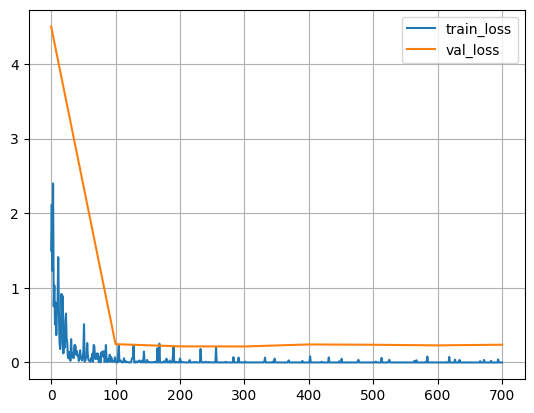

In [11]:
plt.plot([i["step"] for i in record_dialted["train"]], [i["loss"] for i in record_dialted["train"]], label="train_loss")
plt.plot([i["step"] for i in record_dialted["val"]], [i["loss"] for i in record_dialted["val"]], label="val_loss")
plt.grid()
plt.legend()
max_loss = max(
    max([i["loss"] for i in record_dialted["train"]]),
    max([i["loss"] for i in record_dialted["val"]])
)
# plt.ylim(0, 4)  # 上浮10%留出余量
plt.show()

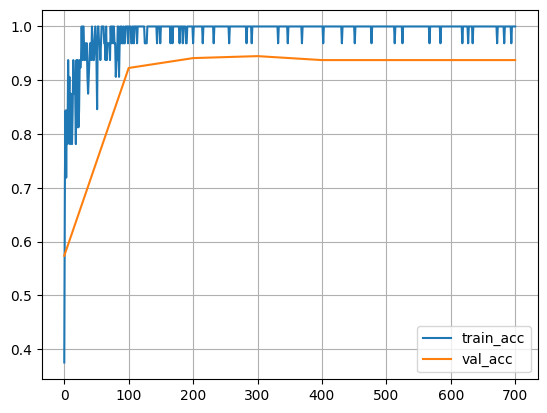

In [12]:
plt.plot([i["step"] for i in record_dialted["train"]], [i["acc"] for i in record_dialted["train"]], label="train_acc")
plt.plot([i["step"] for i in record_dialted["val"]], [i["acc"] for i in record_dialted["val"]], label="val_acc")
plt.grid()
plt.legend()
max_acc = max(
    max([i["acc"] for i in record_dialted["train"]]),
    max([i["acc"] for i in record_dialted["val"]])
)
# plt.ylim(0.6, 1)  # 上浮10%留出余量
plt.show()

In [13]:
model_dialted3.eval()
loss, acc = evaluating(model_dialted3, test_dl_vehicle, loss_fct_dialted)
print(f"loss:     {loss:.4f}\nacc: {acc:.4f}")

loss:     0.2215
acc: 0.9449
